In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
)

# Make plots a bit larger by default
plt.rcParams['figure.figsize'] = (7, 5)

We use a toy example similar to the slides:

Weather: Sunny or Rainy

Windy: 0 (No) or 1 (Yes)

Play: 1 (Play) or 0 (Do not play)

We first create this dataset as a pandas DataFrame.

In [5]:
#Create a small synthetic dataset
data = {
    'Weather': ['Sunny', 'Rainy', 'Sunny', 'Sunny', 'Rainy', 'Rainy', 'Sunny', 'Rainy'],
    'Windy':   [0,        1,       0,        1,        0,        1,        0,       1],
    'Play':    [1,        0,       1,        1,        0,        0,        1,       0]
}

df_synthetic = pd.DataFrame(data)
df_synthetic

,Weather,Windy,Play
0,Sunny,0,1
1,Rainy,1,0
2,Sunny,0,1
3,Sunny,1,1
4,Rainy,0,0
5,Rainy,1,0
6,Sunny,0,1
7,Rainy,1,0


In [6]:
#encode categorical feature and prepare x,y

df_synthetic['Weather_num']= df_synthetic['Weather'].map({'Sunny':1, 'Rainy':0})
X_syn = df_synthetic[['Weather_num','Windy']]
y_syn = df_synthetic['Play']
print(X_syn)
print(y_syn)

   Weather_num  Windy
0            1      0
1            0      1
2            1      0
3            1      1
4            0      0
5            0      1
6            1      0
7            0      1
0    1
1    0
2    1
3    1
4    0
5    0
6    1
7    0
Name: Play, dtype: int64


We now train a decision tree classifier.

We set max_depth=3 just to keep the tree small.

We fit the model on all data (since the goal here is intuition, not evaluation).

In [7]:
#Train a simple decision tree
tree_syn = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_syn.fit(X_syn,y_syn)
tree_syn

DecisionTreeClassifier(max_depth=3, random_state=42)

Now we plot the tree. This helps students see:

The root split

Branches

Leaf predictions

How many samples go to each node

Note: class_names=['No', 'Yes'] aligns with Play: 0 = No, 1 = Yes.

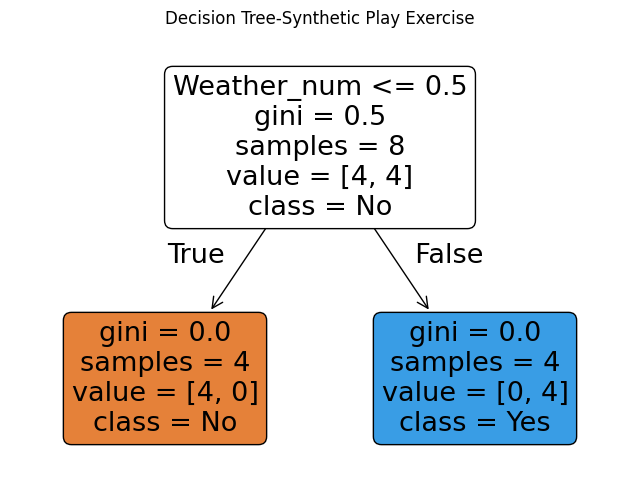

In [8]:

#Visualize the tree
plt.figure(figsize=(8,6))
plot_tree(
    tree_syn,
    feature_names=['Weather_num','Windy'],
    class_names = ['No', 'Yes'],
    filled = True,
    rounded = True,
)
plt.title("Decision Tree-Synthetic Play Exercise")
plt.show()

In [11]:
# Example: Sunny (1), not windy (0)
example_1 = pd.DataFrame([[1,0]], columns = ['Weather_num', 'Windy'])
pred_1 = tree_syn.predict(example_1)[0] #prediction er 0 value ta dekhbo
print('Sunny, not windy -> Play prediction: ',pred_1)

# Example: Rainy (0), windy (1)
example_2 = pd.DataFrame([[0,1]], columns = ['Weather_num', 'Windy'])
pred_2 = tree_syn.predict(example_2)[0]
print('Rainy, windy -> Play prediction: ',pred_2)

Sunny, not windy -> Play prediction:  1
Rainy, windy -> Play prediction:  0


We create a synthetic binary classification dataset using sklearn.datasets.
make_classification. This is not a real medical dataset, but it is enough to show overfitting clearly.

In [10]:
#Create a slightly larger synthetic dataset
from sklearn.datasets import make_classification

X_big, y_big = make_classification(
    n_samples=400, #Total data points
    n_features=5, #Total feature number
    n_informative=3, #Total relevant features
    n_redundant=0, #No strong correlation among the features
    n_classes=2, #Target variable/feature class number
    random_state=42, #Every time we will get the similar random dataset
)

X_train_big, X_test_big, y_train_big, y_test_big = train_test_split(
    X_big, y_big, test_size=0.3, random_state=42
)

X_train_big.shape, X_test_big.shape

((280, 5), (120, 5))

In [13]:
#Train a deep tree vs a pruned tree
deep_tree = DecisionTreeClassifier(random_state=42)
deep_tree.fit(X_train_big, y_train_big)

pruned_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
pruned_tree.fit(X_train_big, y_train_big)

y_train_pred_deep = deep_tree.predict(X_train_big)
y_test_pred_deep = deep_tree.predict(X_test_big)

y_train_pred_pruned = pruned_tree.predict(X_train_big)
y_test_pred_pruned = pruned_tree.predict(X_test_big)

print('Deep tree – train accuracy:', round(accuracy_score(y_train_big, y_train_pred_deep), 3))
print('Deep tree – test accuracy :', round(accuracy_score(y_test_big, y_test_pred_deep), 3))
print()
print('Pruned tree – train accuracy:', round(accuracy_score(y_train_big, y_train_pred_pruned), 3))
print('Pruned tree – test accuracy :', round(accuracy_score(y_test_big, y_test_pred_pruned), 3))

Deep tree – train accuracy: 1.0
Deep tree – test accuracy : 0.883

Pruned tree – train accuracy: 0.904
Pruned tree – test accuracy : 0.892


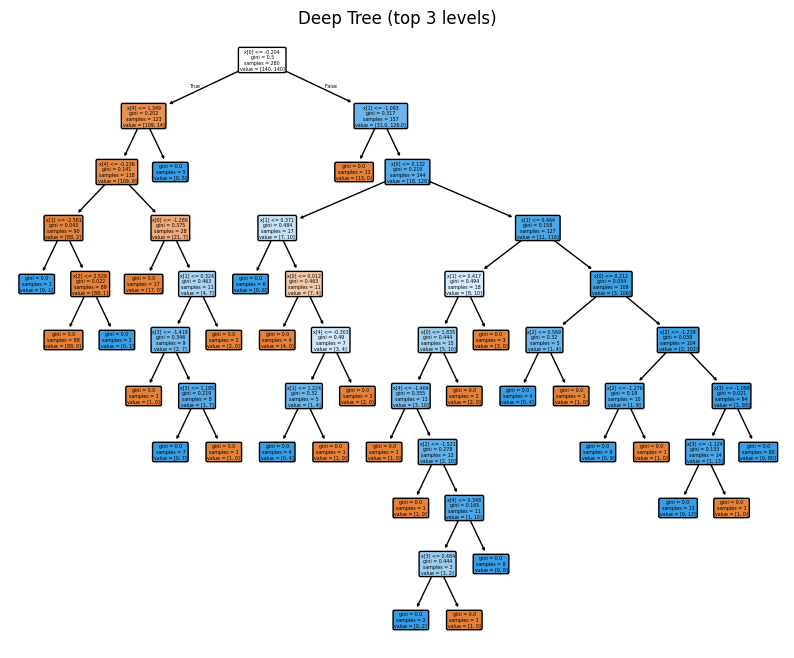

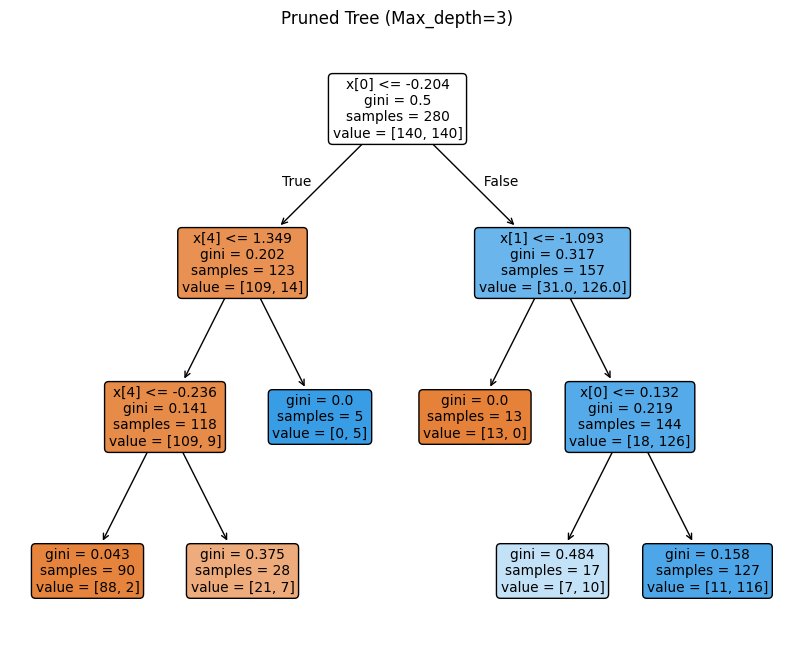

In [14]:
# Plot deep tree (showing only top levels for readability)
plt.figure(figsize=(10,8))
plot_tree(deep_tree, filled=True,rounded=True)
plt.title("Deep Tree (top 3 levels)")
plt.show()

# Plot pruned tree
plt.figure(figsize=(10,8))
plot_tree(pruned_tree, filled=True,rounded=True)
plt.title("Pruned Tree (Max_depth=3)")
plt.show()

# Evaluating a Decision Tree (Accuracy, Precision, Recall, F1, Confusion Matrix)

In this section, we will:


Create a heart-disease-like synthetic dataset

Train a decision tree classifier

Compute and interpret:

Confusion matrix

Accuracy

Precision

Recall

F1 score


In [15]:
np.random.seed(42)
n_samples = 300

age = np.random.randint(30, 80, size=n_samples)
chol = np.random.randint(150, 300, size=n_samples)
thalach = np.random.randint(90, 200, size=n_samples)

# We create a simple rule-based probability for disease just for realism
risk_score = 0.03 * (age - 40) + 0.02 * (chol - 200) - 0.02 * (thalach - 140)
prob = 1 / (1 + np.exp(-0.05 * risk_score))

target = (prob > np.median(prob)).astype(int)

df_heart = pd.DataFrame({
    'age': age,
    'chol': chol,
    'thalach': thalach,
    'target': target
})

df_heart.head(10)

,age,chol,thalach,target
0,68,253,128,1
1,58,233,90,1
2,44,261,92,1
3,72,248,166,1
4,37,242,181,0
5,50,295,151,1
6,68,277,152,1
7,48,259,114,1
8,52,231,145,0
9,40,203,122,0


In [16]:
#Train-test split and model training
X_heart = df_heart[['age','chol','thalach']]
y_heart = df_heart['target']

X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_heart, y_heart, test_size=0.2, random_state=42
)

tree_heart = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_heart.fit(X_train_h, y_train_h)

tree_heart

DecisionTreeClassifier(max_depth=4, random_state=42)

In [17]:
#Confusion matrix
y_pred_h = tree_heart.predict(X_test_h)

cm = confusion_matrix(y_test_h, y_pred_h)
print(cm)

[[23  3]
 [ 6 28]]


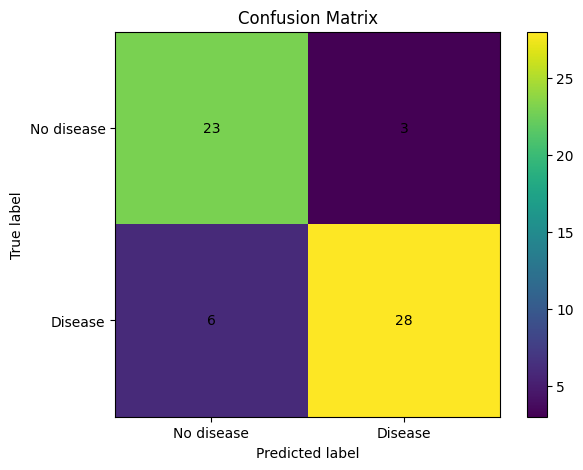

In [18]:
#Plot of Confusion Matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation = 'nearest')
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

# Show all ticks and label them
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(["No disease", 'Disease'])
ax.set_yticklabels(["No disease", 'Disease'])

# Loop over data dimensions and create text annotations.
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(j,i,cm[i,j], ha='center', va='center')

plt.colorbar(im)
plt.show()

In [19]:
#Accuracy, precision, recall, F1
acc = accuracy_score(y_test_h,y_pred_h)
prec = precision_score(y_test_h,y_pred_h)
rec = recall_score(y_test_h,y_pred_h)
f1 = f1_score(y_test_h,y_pred_h)

print('Accuracy :', round(acc, 3))
print('Precision:', round(prec, 3))
print('Recall   :', round(rec, 3))
print('F1 score :', round(f1, 3))

Accuracy : 0.85
Precision: 0.903
Recall   : 0.824
F1 score : 0.862


Is this model missing many disease cases? (look at recall)

ans : Recall = 0.824 means the model is correctly identifying 82.4% of the actual disease cases.
So yes, it is missing some disease cases, but not too many — about 17.6% of real disease patients are being missed.


Is it falsely alarming many healthy patients? (look at precision)

ans : Precision = 0.903 means that 90.3% of the patients predicted as “diseased” are actually sick.
So false alarms are low — only 9.7% of healthy patients are wrongly flagged.


Does F1 look balanced?

ans : Yes. F1 = 0.862 shows a good balance between precision and recall.
This means the model is performing well in both detecting real disease cases and avoiding false alarms.

In [20]:
#Predicted probabilities
y_proba_h = tree_heart.predict_proba(X_test_h)[:, 1]
y_proba_h[:10]

array([0.875     , 0.        , 0.04761905, 0.        , 0.875     ,
       1.        , 1.        , 1.        , 1.        , 0.        ])

In [21]:
#ROC curve and AUC
fpr,tpr,thresholds = roc_curve(y_test_h, y_proba_h)
roc_auc = auc(fpr,tpr)
print('AUC: ',round(roc_auc, 3))

AUC:  0.925


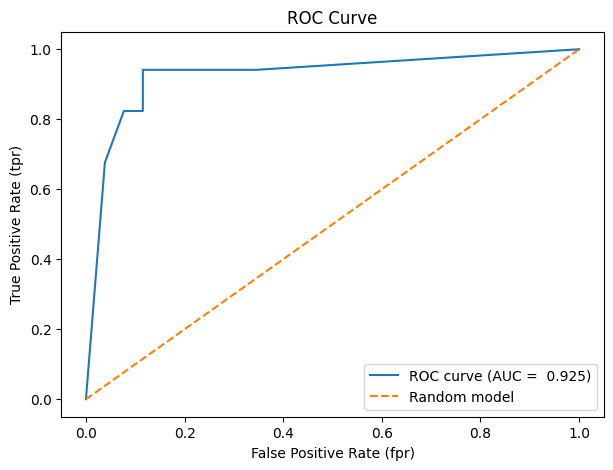

In [22]:
#Plot
plt.figure()
plt.plot(fpr,tpr, label=f'ROC curve (AUC = {roc_auc: .3f})')
plt.plot([0,1], [0,1], linestyle='--', label='Random model')
plt.xlabel('False Positive Rate (fpr)')
plt.ylabel('True Positive Rate (tpr)')
plt.title("ROC Curve")
plt.legend()
plt.show()